In [82]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras import optimizers, utils
from tensorflow.keras.callbacks import ModelCheckpoint
from glob import glob

In [2]:
COLOR_CHANNELS = 3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64

In [21]:
# importing ship dataset from json
f = open('kaggle/input/ships-in-satellite-imagery/shipsnet.json')
ship_data = json.load(f)
f.close()

# separating images containing ships
ships = []
no_obj1 = []
for index, element in enumerate(ship_data['labels']):
    if element == 1: ships.append(index)
    else: no_obj1.append(index)

# split images and labels for ship images
ship_images = np.array([ship_data['data'][i] for i in ships]).astype('uint8')
y_ships = np.array([ship_data['labels'][i] for i in ships])

# split images and labels for no object images
no_object1 = np.array([ship_data['data'][i] for i in no_obj1]).astype('uint8')
y_no_obj1 = np.array([ship_data['labels'][i] for i in no_obj1])
y_no_obj1 = np.where(y_no_obj1 == 0, 3, y_no_obj1)

# preprocessing ship images
X_ships = ship_images.reshape([-1, COLOR_CHANNELS, 80, 80])
X_ships = np.moveaxis(X_ships, 1, 3)
X_ships = tf.image.resize(X_ships, [IMAGE_HEIGHT, IMAGE_WIDTH]).numpy()

# preprocessing no object images
X_no_obj1 = no_object1.reshape([-1, COLOR_CHANNELS, 80, 80])
X_no_obj1 = np.moveaxis(X_no_obj1, 1, 3)
X_no_obj1 = tf.image.resize(X_no_obj1, [IMAGE_HEIGHT, IMAGE_WIDTH]).numpy()

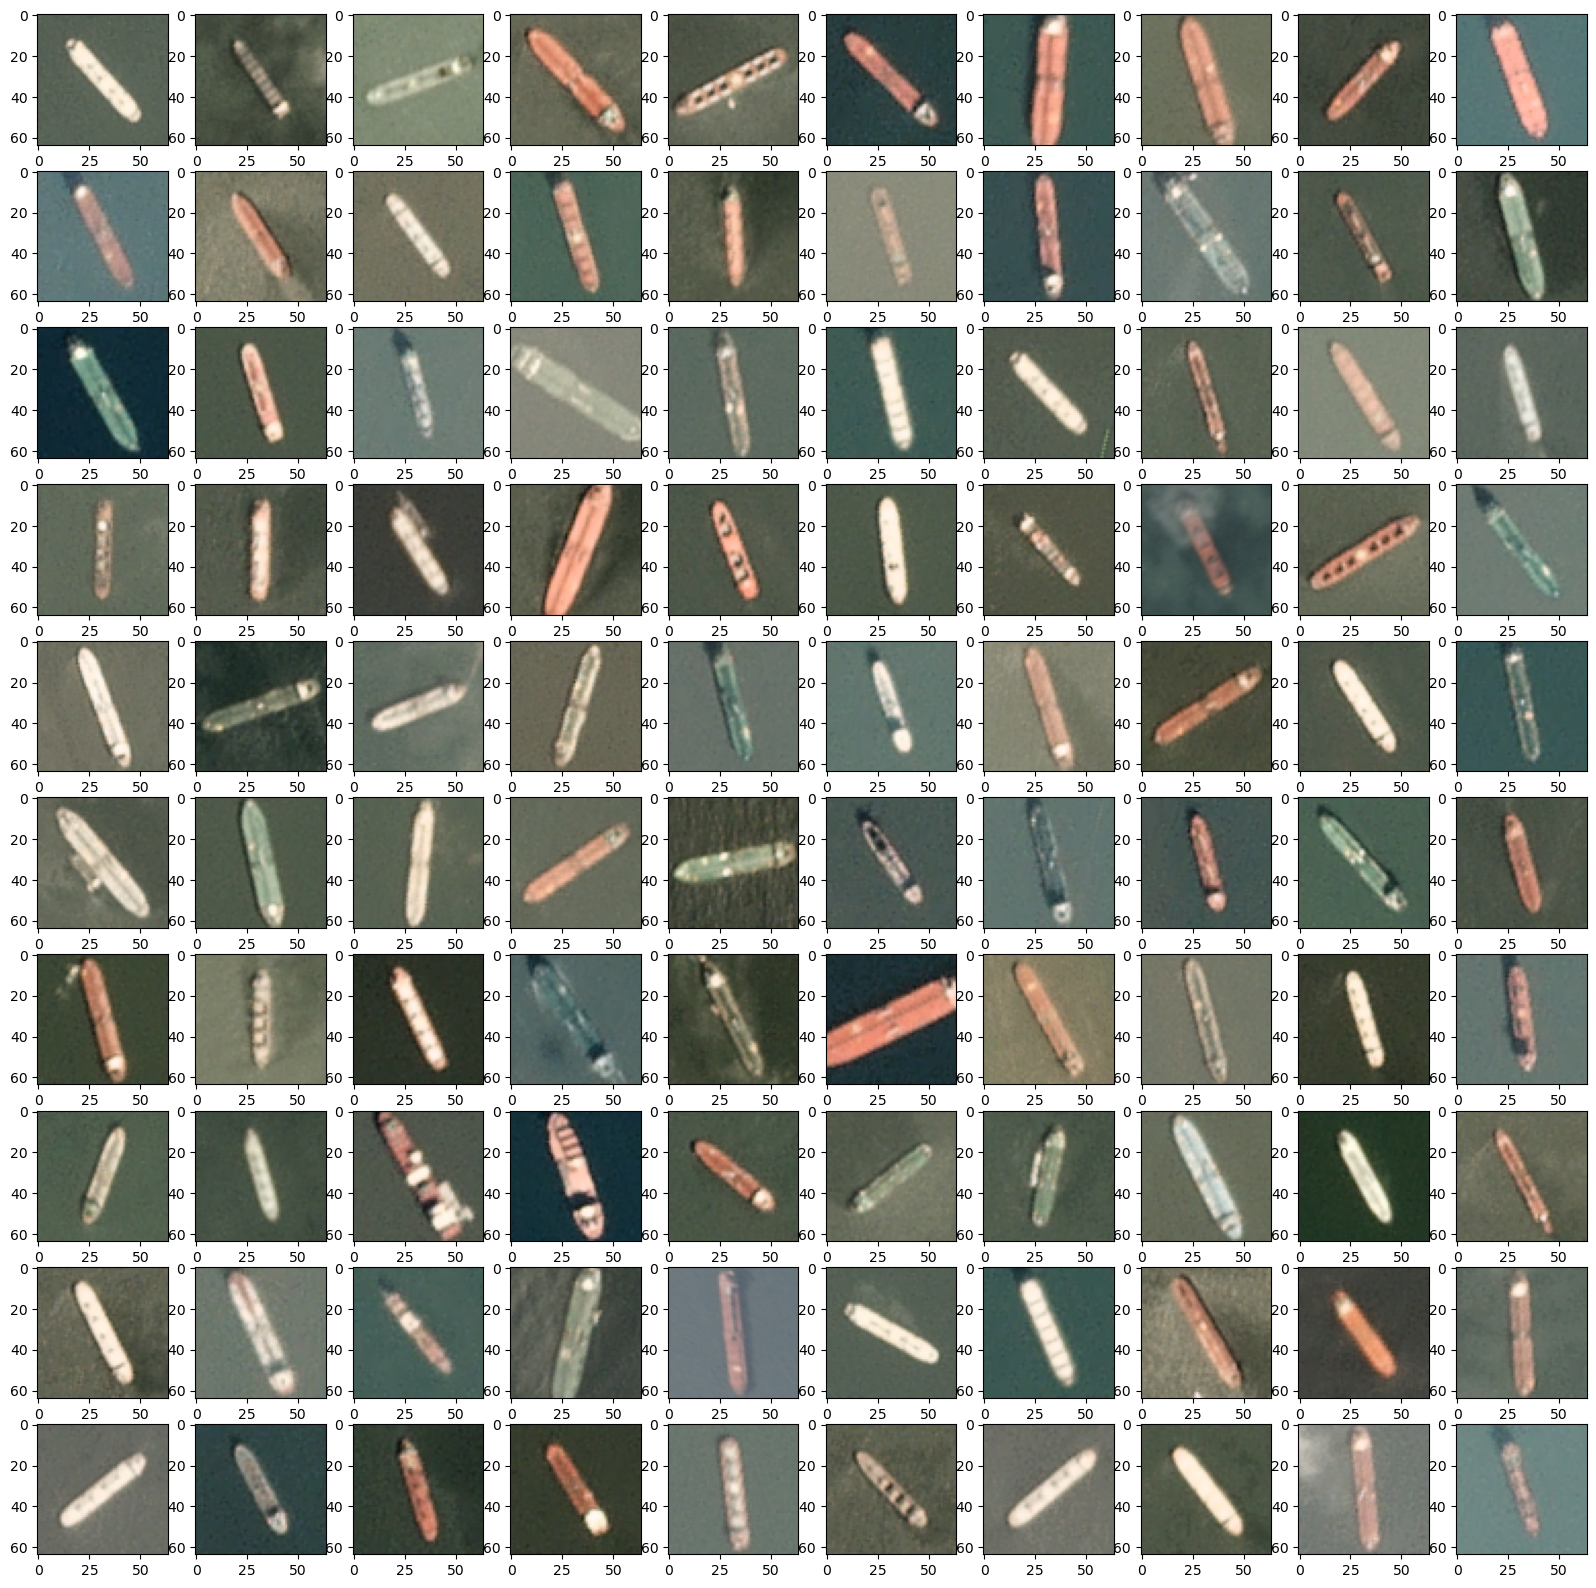

In [22]:
# visualizing ship images
fig, axes = plt.subplots(10, 10, figsize=(20, 20))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_ships[i].astype('uint8'))

In [23]:
# importing aircraft dataset from json
f = open('kaggle/input/planesnet/planesnet.json')
plane_data = json.load(f)
f.close()

# saving scenes for validation


# separating images containing planes
planes = []
no_obj2 = []
scenes = []
for index, element in enumerate(plane_data['labels']):
    if element == 1: planes.append(index)
    else: no_obj2.append(index)

# splitting images and labels for plane images
plane_images = np.array([plane_data['data'][i] for i in planes]).astype('uint8')
y_planes = np.array([plane_data['labels'][i] for i in planes])
y_planes = np.where(y_planes == 1, 2, y_planes)

# splitting images and labels for no object images
no_object2 = np.array([plane_data['data'][i] for i in no_obj2]).astype('uint8')
y_no_obj2 = np.array([plane_data['labels'][i] for i in no_obj2])
y_no_obj2 = np.where(y_no_obj2 == 1, 3, y_no_obj2)

# preprocessing plane images
X_planes = plane_images.reshape([-1, COLOR_CHANNELS, 20, 20])
X_planes = np.moveaxis(X_planes, 1, 3)
X_planes = tf.image.resize(X_planes, [IMAGE_HEIGHT, IMAGE_WIDTH]).numpy()

# preprocessing no object images
X_no_obj2 = no_object2.reshape([-1, COLOR_CHANNELS, 20, 20])
X_no_obj2 = np.moveaxis(X_no_obj2, 1, 3)
X_no_obj2 = tf.image.resize(X_no_obj2, [IMAGE_HEIGHT, IMAGE_WIDTH]).numpy()

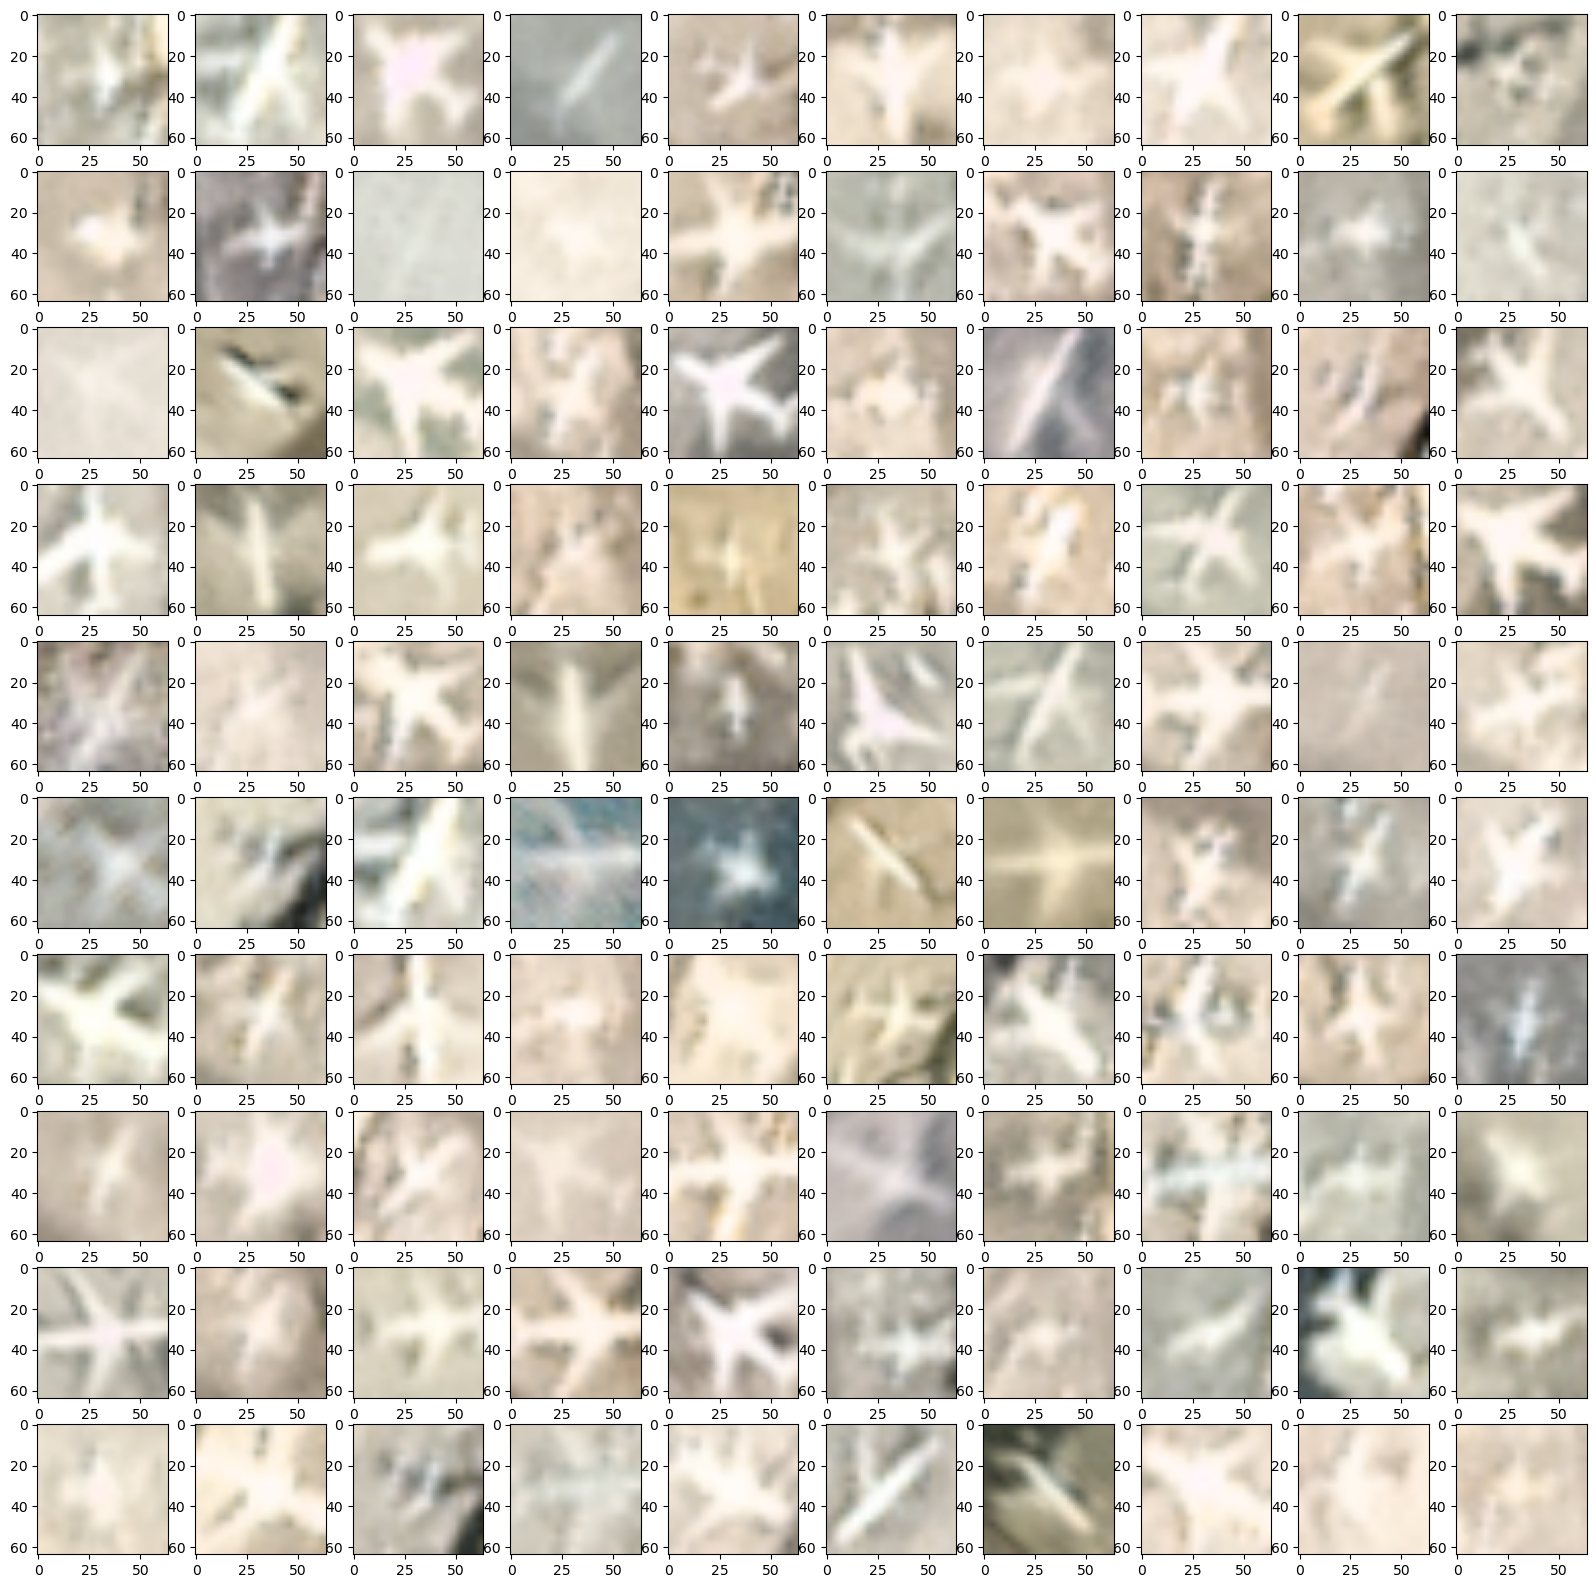

In [24]:
# visualizing plane images
fig1, axes = plt.subplots(10,10, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_planes[i].astype('uint8'))

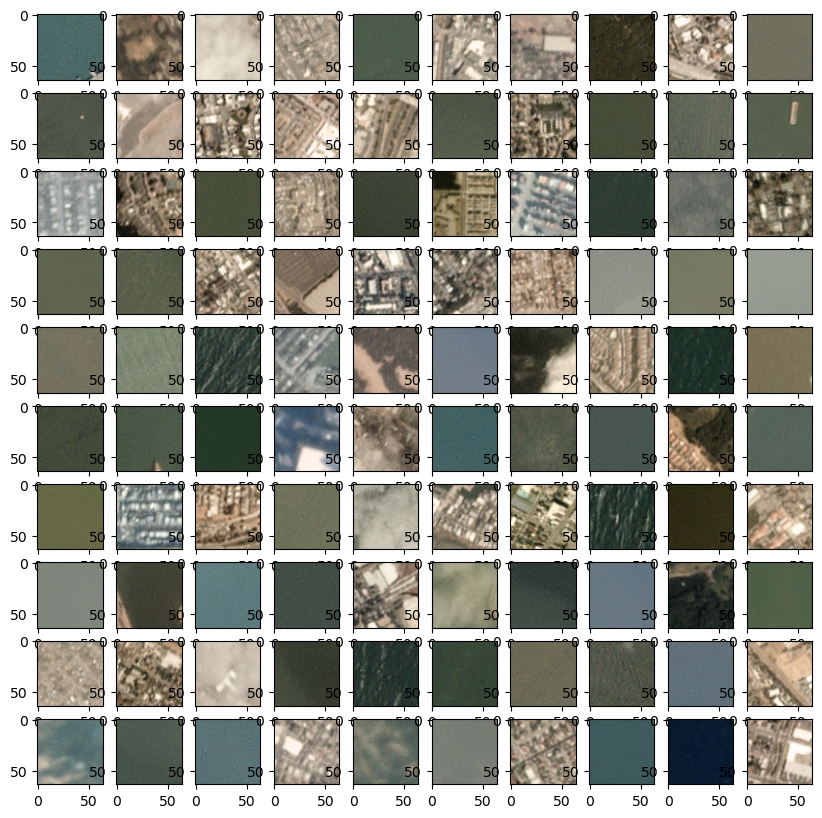

In [31]:
# concatenating no object image sets
X_no_objects = np.concatenate((X_no_obj1, X_no_obj2))
y_no_objects = np.concatenate((y_no_obj1, y_no_obj2))

# visualizing no object dataset
fig1, axes = plt.subplots(10,10, figsize=(20,20))
for i,ax in enumerate(axes.flat):
    ax.imshow(X_no_objects[i].astype('uint8'))

In [27]:
X_planes.shape

(8000, 64, 64, 3)

In [28]:
X_ships.shape

(1000, 64, 64, 3)

In [29]:
X_no_objects.shape

(27000, 64, 64, 3)

In [30]:
# concatenating datasets
X_data = np.concatenate((X_ships, X_planes, X_no_objects))
y_data = np.concatenate((y_ships, y_planes, y_no_objects))

In [32]:
# splitting dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, train_size=0.7, test_size=0.3, shuffle=True, random_state=42)

# one-hot encoding y_train variable
y_train = tf.one_hot(y_train, depth=3)

In [44]:
# building CNN model
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(64, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding="same"))
model.add(MaxPooling2D((2,2), padding='same'))
model.add(BatchNormalization())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(64, activation='relu'))
model.add(Dropout(0.25))
model.add(BatchNormalization())

model.add(Dense(3, activation='softmax'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("model.keras", monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
history = model.fit(X_train, y_train, batch_size=16, validation_split=0.07, epochs=40, callbacks=[checkpoint])

Epoch 1/40
1465/1465 [==============================] - ETA: 0s - loss: 0.2240 - accuracy: 0.8663
Epoch 1: val_accuracy improved from -inf to 0.80612, saving model to model.keras
1465/1465 [==============================] - 56s 30ms/step - loss: 0.2240 - accuracy: 0.8663 - val_loss: 0.4838 - val_accuracy: 0.8061
Epoch 2/40
1464/1465 [============================>.] - ETA: 0s - loss: 0.1239 - accuracy: 0.9142
Epoch 2: val_accuracy did not improve from 0.80612
1465/1465 [==============================] - 44s 30ms/step - loss: 0.1239 - accuracy: 0.9142 - val_loss: 0.5964 - val_accuracy: 0.7228
Epoch 3/40
1465/1465 [==============================] - ETA: 0s - loss: 0.0916 - accuracy: 0.9291
Epoch 3: val_accuracy improved from 0.80612 to 0.94388, saving model to model.keras
1465/1465 [==============================] - 44s 30ms/step - loss: 0.0916 - accuracy: 0.9291 - val_loss: 0.0553 - val_accuracy: 0.9439
Epoch 4/40
1465/1465 [==============================] - ETA: 0s - loss: 0.0734 - accu

Epoch 29/40
1464/1465 [============================>.] - ETA: 0s - loss: 0.0186 - accuracy: 0.9684
Epoch 29: val_accuracy improved from 0.98243 to 0.98696, saving model to model.keras
1465/1465 [==============================] - 52s 36ms/step - loss: 0.0186 - accuracy: 0.9684 - val_loss: 0.0268 - val_accuracy: 0.9870
Epoch 30/40
1464/1465 [============================>.] - ETA: 0s - loss: 0.0097 - accuracy: 0.9755
Epoch 30: val_accuracy did not improve from 0.98696
1465/1465 [==============================] - 47s 32ms/step - loss: 0.0096 - accuracy: 0.9756 - val_loss: 0.0613 - val_accuracy: 0.9762
Epoch 31/40
1464/1465 [============================>.] - ETA: 0s - loss: 0.0125 - accuracy: 0.9735
Epoch 31: val_accuracy did not improve from 0.98696
1465/1465 [==============================] - 46s 31ms/step - loss: 0.0125 - accuracy: 0.9735 - val_loss: 0.2555 - val_accuracy: 0.9031
Epoch 32/40
1464/1465 [============================>.] - ETA: 0s - loss: 0.0111 - accuracy: 0.9735
Epoch 32: 

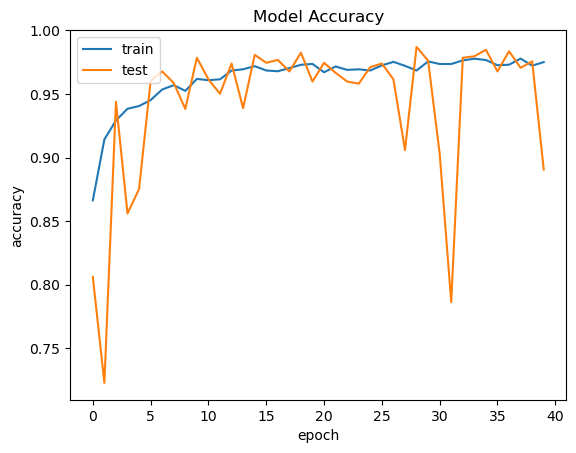

In [45]:
# visualizing accuracy of model
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

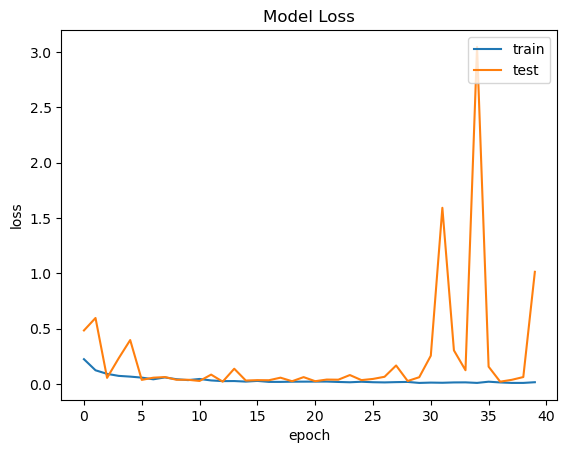

In [46]:
# visualizing model loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [71]:
# making predictions
# y_test = tf.one_hot(y_test, depth=3)

predictions = model.predict(X_test)
prediction_probability = np.max(predictions, axis=1) * 100
predictions = np.argmax(predictions, axis=1)
ground_truth = np.argmax(y_test, axis=1)

correct_predictions = []
incorrect_predictions = []

for i in range(len(predictions)):
    if predictions[i] == ground_truth[i]: correct_predictions.append(i)
    else: incorrect_predictions.append(i)

338/338 [==============================] - 10s 29ms/step


In [54]:
model.evaluate(X_test, y_test)

338/338 [==============================] - 10s 28ms/step - loss: 1.5728 - accuracy: 0.8836


[1.572843074798584, 0.8836110830307007]

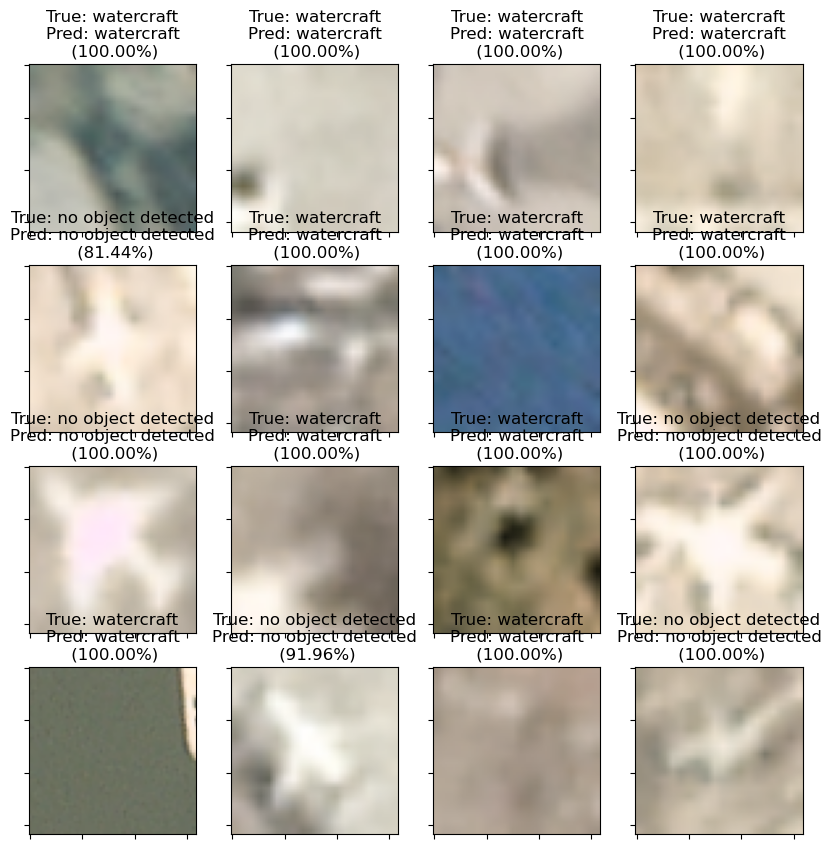

In [76]:
# visualizing correct predictions
class_labels = ['watercraft', 'aircraft', 'no object detected']

plt.figure(figsize=(10, 10))
for i in range(16):
    ax = plt.subplot(4, 4, i+1)
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    plt.imshow(X_test[correct_predictions[i]].astype('uint8'))
    plt.title('True: ' + str(class_labels[ground_truth[correct_predictions[i]]]) + 
              '\nPred: ' + str(class_labels[predictions[correct_predictions[i]]]) +
              '\n' + " (%.2f%%)" % prediction_probability[correct_predictions[i]])